In [1]:
import pickle
import numpy as np
import numba
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from librosa.sequence import dtw
from matplotlib import gridspec
from speechCommon import *
import time
import os

In [2]:
user = 'agoutam'

hyp_dir = '/home/{}/ttemp/TamperingDetection/hyp'.format(user)
all_ids = '/home/{}/ttemp/TamperingDetection/data/cfg_files/all.ids'.format(user)
train_ids = '/home/{}/ttemp/TamperingDetection/data/cfg_files/train.ids'.format(user)

editTimeSec = 2

base_dir = "../ttemp/TamperingDetection"

In [3]:
def dist(query_id, edit_type, piece):
    mfcc_ref = readMFCC(base_dir, query_id, piece_type = 'reference')
    mfcc_query = readMFCC(base_dir, query_id, piece_type = 'queries', edit_type=edit_type+str(piece), editTimeSec = editTimeSec)
    
    C = euclidean_distances(mfcc_query, mfcc_ref)
    return C

In [4]:
@numba.jit(nopython=True)
def NWTWDP(C, alpha, beta=20, gamma = 1):
    # 0: visible, 1: hidden
    # B: 1 Diag, 2 Right, 3 Up, 0 switch plane
    # initialization
    D = np.zeros((2, C.shape[0], C.shape[1]))
    B = np.zeros((2, C.shape[0], C.shape[1]))
    
    # bottom rows
    D[0, 0, :] = C[0, :]
    D[1, 0, :] = np.inf
    
    # first cols
    for i in range(1, C.shape[0]):
        D[0, i, 0] = D[0, i-1, 0] + alpha
        D[1, i, 0] = D[0, i, 0]
        B[0, i, 0] = 3
        B[1, i, 0] = 0
        
    # rest of the matrix
    for i in range(1, C.shape[0]):
        for j in range(1, C.shape[1]):
        
            # hidden
            # diag visible -> hidden, right in hidden, up in hidden
            costs = np.array([D[0, i-1, j-1] + gamma + alpha, np.inf, D[1, i, j-1] + gamma, D[1, i-1, j] + alpha])
            D[1, i, j] = np.min(costs)
            B[1, i, j] = np.argmin(costs)
                
            # visible
            # hidden -> visible, diag
            costs = np.array([D[1, i, j] + beta, D[0, i-1, j-1] + C[i, j]])
            D[0, i, j] = np.min(costs)
            B[0, i, j] = np.argmin(costs)
            
    return B, D

In [5]:
#@numba.jit(nopython=True)
def backtrace3D(B, D):
    p = 0
    r = D.shape[1] - 1
    c = np.argmin(D[0, -1])
    path_3D = []
    while r > 0:
        path_3D.append([p,r,c])
        if B[p, r, c] == 0 and p == 0:
            p = 1
            r -= 1
            c -= 1
        elif B[p, r, c] == 0 and p == 1:
            p = 0
        elif B[p, r, c] == 1:
            r -= 1
            c -= 1
        elif B[p, r, c] == 2:
            c -= 1
        elif B[p, r, c] == 3:
            r -= 1
    return np.asarray(path_3D)

In [6]:
def alignNWTWDP3D(query_id, edit_type, piece, Ca = 3, Cb = 7, gamma = 1):
    C = dist(query_id, edit_type, piece)
    alpha = np.median(np.min(C, axis=1)) * Ca
    B, D = NWTWDP(C, alpha, beta=(alpha+gamma)*Cb)
    path_3D = backtrace3D(B, D)
    return path_3D, C

In [7]:
def alignDTW(query_id, edit_type, piece, weightSet = 'D1'):
    #mfcc_ref, mfcc_query = readMFCC(query_id, edit_type=edit_type+str(piece))
    mfcc_ref = readMFCC(base_dir, query_id, piece_type = 'reference')
    mfcc_query = readMFCC(base_dir, query_id, piece_type = 'queries', edit_type=edit_type+str(piece), editTimeSec = editTimeSec)
    D, wp = dtw(mfcc_query.T, mfcc_ref.T, subseq=True, step_sizes_sigma=sigma, weights_mul=dtw_weights[weightSet])
    return wp

In [8]:
startTime = time.time()
query_id = '12_2_17'
edit_type = 'r'
piece = 2
path_3D, C = alignNWTWDP3D(query_id, edit_type, piece, 40)
path_d = alignDTW(query_id, edit_type, piece)
print(time.time() - startTime)

path_v = path_3D[np.where(path_3D[:,0] == 0)][:,1:3]
path_h = path_3D[np.where(path_3D[:,0] == 1)][:,1:3]

3.8494696617126465


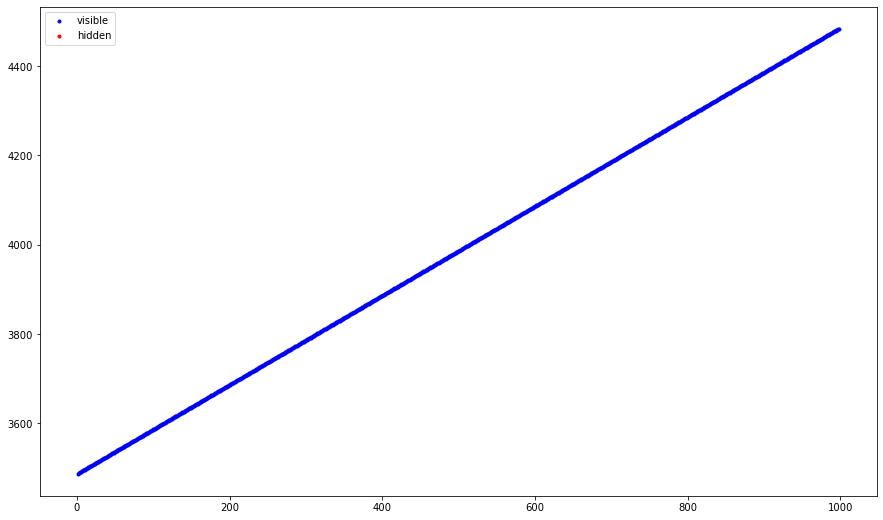

In [9]:
shifter = 0

plt.figure(figsize = (15,9))
#plt.imshow(C.T, aspect = 'auto')
plt.scatter(path_v[:,0], path_v[:,1], color = 'b', marker = '.')
plt.scatter(path_h[:,0], path_h[:,1], color = 'r', marker = '.')
plt.legend(['visible','hidden'])
plt.show()

In [119]:
def alignAndSave(filename, query_id, editTimeSec, edit_type, piece):
    if query_id == '00' or piece in [11, 12, 13]:
        return
    print(filename)
    if not os.path.exists(filename):
    #if True:
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        path_3D, C = alignNWTWDP3D(query_id, edit_type, piece, Cb = 7)
        path_3D = np.hstack((path_3D[:,1:3], path_3D[:,0,None]))
        elem = path_3D[0]
        prevPlane = elem[2]
        costs = [C[elem[0], elem[1]]]
        for elem in path_3D[1:]:
            curPlane = elem[2]
            if(curPlane == 0 and prevPlane == 1):
                continue
            else:
                costs.append(C[elem[0], elem[1]])
                
        res = {}
        res['wp'] = path_3D
        res['dist'] = np.asarray(costs)
        res['size'] = C.shape
        with open(filename, 'wb') as f:
            pickle.dump(res, f)

In [120]:
total = 0
benchmark = 'shortTrain'
with open ('/home/{}/ttemp/TamperingDetection/cfg_files/{}.ids'.format(user, benchmark), 'r') as f:
    for i, query_id in enumerate(f.read().split('\n')):
        if(query_id == ''):
            continue
        print(i, query_id)
        for edit_type in ['i','r','d','n']:
            for piece in range(1, 11):
                filename = '{}/{}/{}sec/{}/{}_{}{}.pkl'.format(hyp_dir, benchmark, editTimeSec, 'HSTW', query_id, edit_type, piece)
                if not os.path.exists(filename):
                    print('aligning', query_id, edit_type, piece)
                    alignAndSave(filename, query_id, editTimeSec, edit_type, piece)
                    total += 1

0 9_8_17
aligning 9_8_17 i 1
/home/agoutam/ttemp/TamperingDetection/hyp/shortTrain/2sec/HSTW/9_8_17_i1.pkl
aligning 9_8_17 i 2
/home/agoutam/ttemp/TamperingDetection/hyp/shortTrain/2sec/HSTW/9_8_17_i2.pkl
aligning 9_8_17 i 3
/home/agoutam/ttemp/TamperingDetection/hyp/shortTrain/2sec/HSTW/9_8_17_i3.pkl
aligning 9_8_17 i 4
/home/agoutam/ttemp/TamperingDetection/hyp/shortTrain/2sec/HSTW/9_8_17_i4.pkl
aligning 9_8_17 i 5
/home/agoutam/ttemp/TamperingDetection/hyp/shortTrain/2sec/HSTW/9_8_17_i5.pkl
aligning 9_8_17 i 6
/home/agoutam/ttemp/TamperingDetection/hyp/shortTrain/2sec/HSTW/9_8_17_i6.pkl
aligning 9_8_17 i 7
/home/agoutam/ttemp/TamperingDetection/hyp/shortTrain/2sec/HSTW/9_8_17_i7.pkl
aligning 9_8_17 i 8
/home/agoutam/ttemp/TamperingDetection/hyp/shortTrain/2sec/HSTW/9_8_17_i8.pkl
aligning 9_8_17 i 9
/home/agoutam/ttemp/TamperingDetection/hyp/shortTrain/2sec/HSTW/9_8_17_i9.pkl
aligning 9_8_17 i 10
/home/agoutam/ttemp/TamperingDetection/hyp/shortTrain/2sec/HSTW/9_8_17_i10.pkl
aligning 

### (Works up till here)

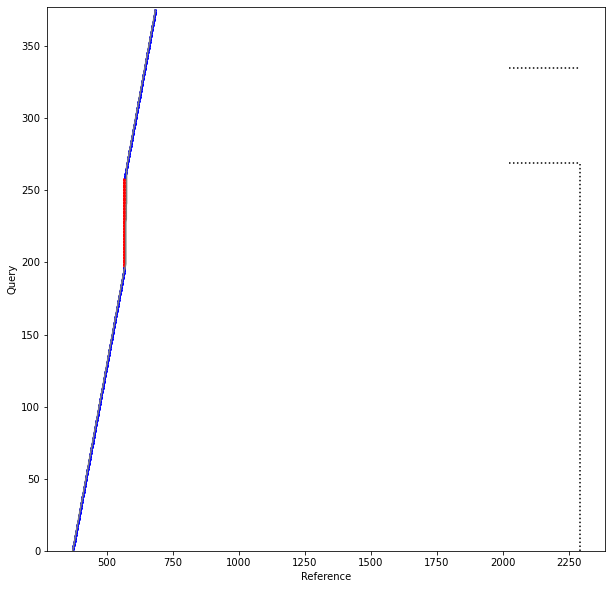

In [13]:
# insertion wrong
query_id = '12_30_17'
edit_type = 'i'
piece = 6
path_v, path_h = alignNWTWDP(query_id, edit_type, piece, 40)
path_d = alignDTW(query_id, edit_type, piece)

path1 = []
for i in range(2023, 2291):
    path1.append([269, i])
path1 = np.array(path1)
path2 = []
for i in range(2023, 2291):
    path2.append([335, i])
path2 = np.array(path2)
path3 = []
for i in range(0, 269):
    path3.append([i, 2291])
path3 = np.array(path3)

plt.figure(figsize=(10, 10))#had dpi = 180
plt.scatter(path_h[:, 1], path_h[:, 0], s=2**2, color='red')
plt.scatter(path_v[:, 1], path_v[:, 0], s=2**2, color='blue')
plt.plot(path_d[:,1], path_d[:,0], color='gray')
plt.plot(path1[:,1], path1[:,0], ':', color='black')
plt.plot(path2[:,1], path2[:,0], ':', color='black')
plt.plot(path3[:,1], path3[:,0], ':', color='black')
plt.xlabel("Reference")
plt.ylabel("Query")
plt.ylim(0, 377) 
#plt.xlim(2023, 2335) 
plt.show()

Text(0, 0.5, 'Query')

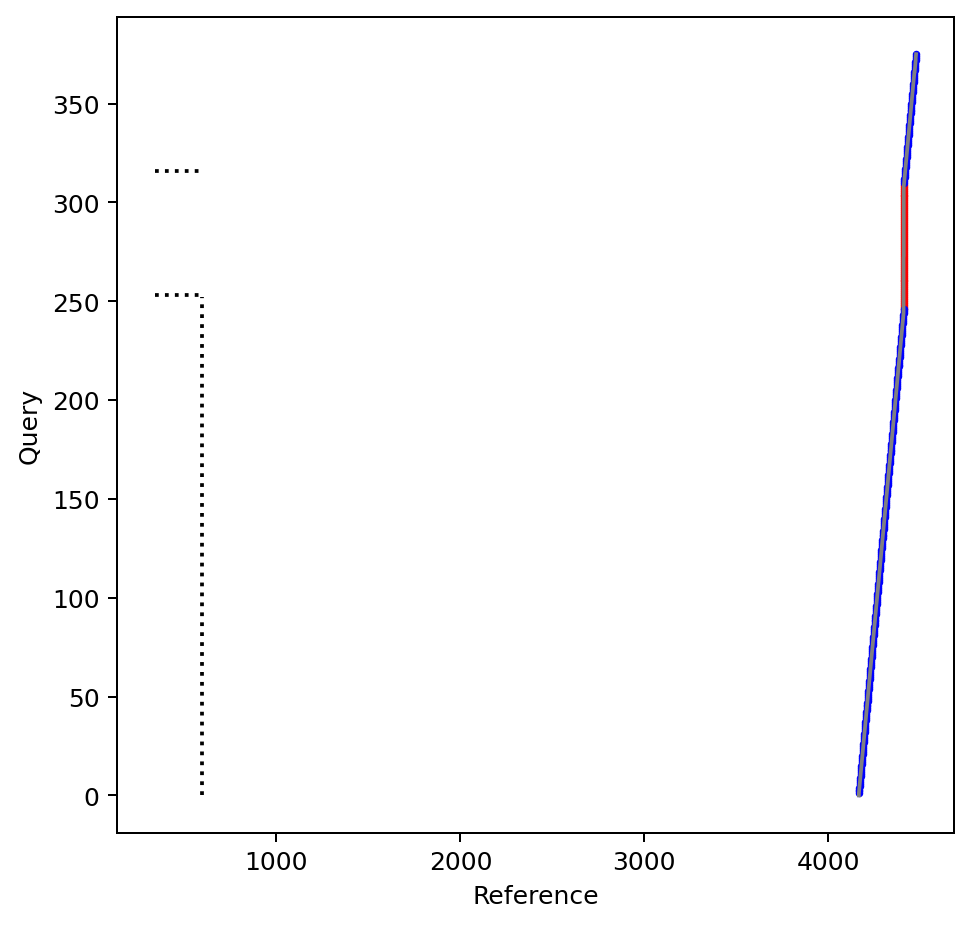

In [21]:
# insertion correct
query_id = '10_6_17'
edit_type = 'i'
piece = 3
path_v, path_h = alignNWTWDP(query_id, edit_type, piece, 100)
path_d = alignDTW(query_id, edit_type, piece)

path1 = []
for i in range(341, 594):
    path1.append([316, i])
path1 = np.array(path1)
path2 = []
for i in range(341, 594):
    path2.append([253, i])
path2 = np.array(path2)
path3 = []
for i in range(0, 253):
    path3.append([i, 594])
path3 = np.array(path3)

plt.figure(figsize=(6, 6), dpi=180)
plt.scatter(path_h[:, 1], path_h[:, 0], s=2**2, color='red')
plt.scatter(path_v[:, 1], path_v[:, 0], s=2**2, color='blue')
plt.plot(path_d[:,1], path_d[:,0], color='gray')
plt.plot(path1[:,1], path1[:,0], ':', color='black')
plt.plot(path2[:,1], path2[:,0], ':', color='black')
plt.plot(path3[:,1], path3[:,0], ':', color='black')
plt.xlabel("Reference")
plt.ylabel("Query")
#plt.ylim(0, 375) 
#plt.xlim(341, 652) 

(2251.0, 2563.0)

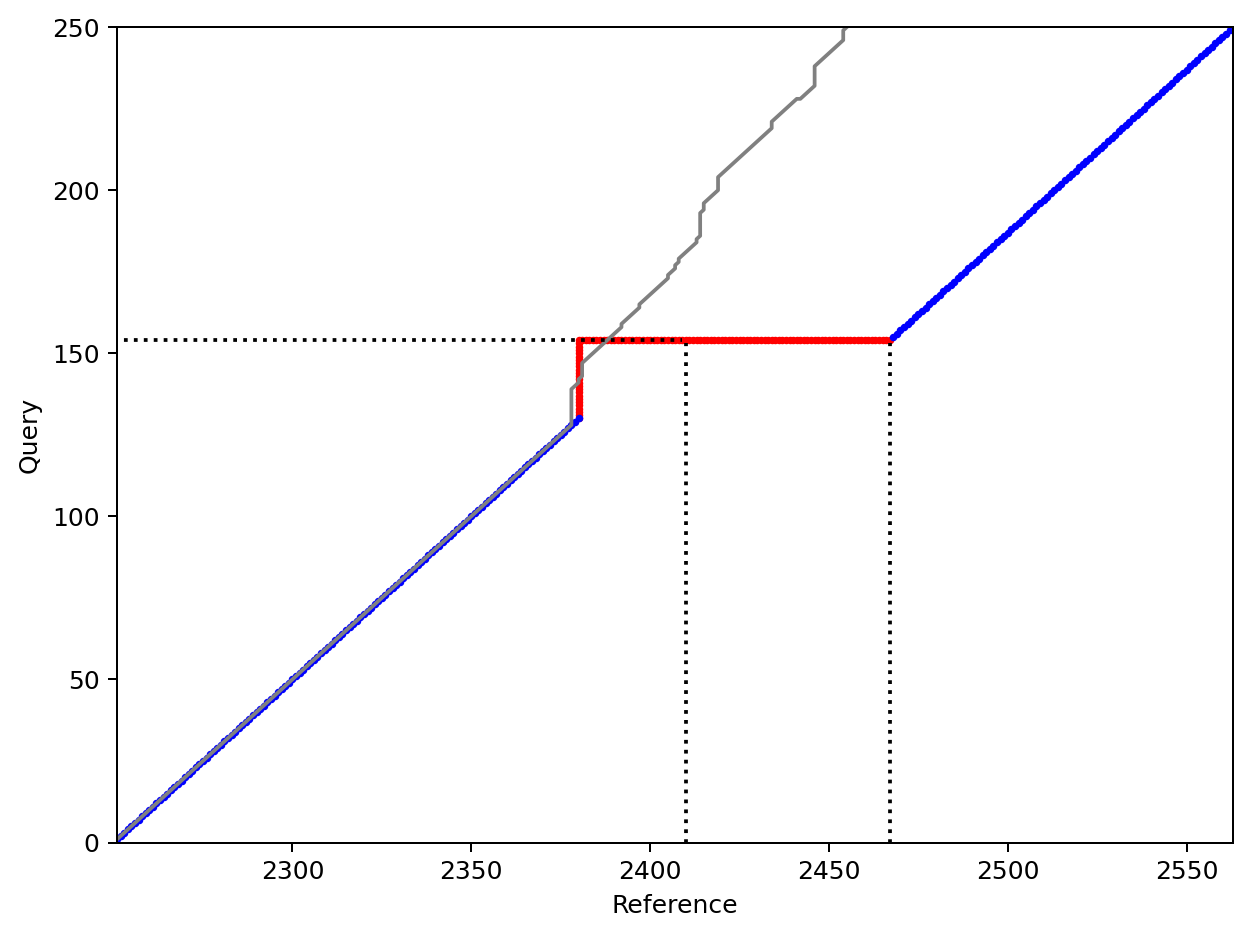

In [45]:
# deletion correct
query_id = '2_10_17'
edit_type = 'd'
piece = 8
path_v, path_h = alignNWTWDP(query_id, edit_type, piece, 40)
path_d = alignDTW(query_id, edit_type, piece)

path1 = []
for i in range(0, 154):
    path1.append([i, 2467])
path1 = np.array(path1)
path2 = []
for i in range(0, 154):
    path2.append([i, 2410])
path2 = np.array(path2)
path3 = []
for i in range(0, 2410):
    path3.append([154, i])
path3 = np.array(path3)


plt.figure(figsize=(8, 6), dpi=180)
plt.scatter(path_h[:, 1], path_h[:, 0], s=2**2, color='red')
plt.scatter(path_v[:, 1], path_v[:, 0], s=2**2, color='blue')
plt.plot(path_d[:,1], path_d[:,0], color='gray')
plt.plot(path1[:,1], path1[:,0], ':', color='black')
plt.plot(path2[:,1], path2[:,0], ':', color='black')
plt.plot(path3[:,1], path3[:,0], ':', color='black')
plt.xlabel("Reference")
plt.ylabel("Query")
plt.ylim(0, 250) 
plt.xlim(2251, 2563) 

(645.0, 957.0)

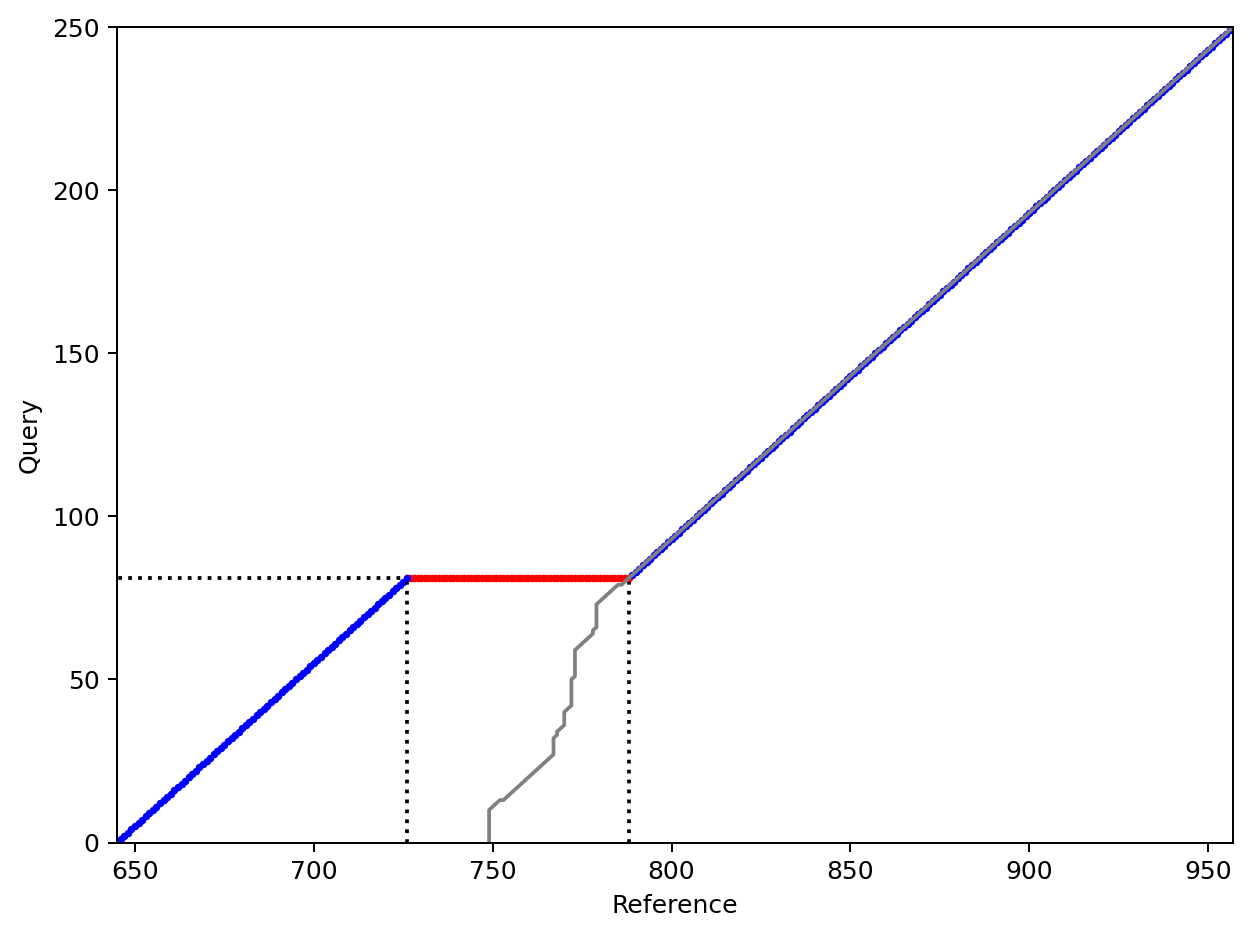

In [44]:
# deletion correct
query_id = '10_6_17'
edit_type = 'd'
piece = 8
path_v, path_h = alignNWTWDP(query_id, edit_type, piece, 100)
path_d = alignDTW(query_id, edit_type, piece)

path1 = []
for i in range(0, 81):
    path1.append([i, 788])
path1 = np.array(path1)
path2 = []
for i in range(0, 81):
    path2.append([i, 726])
path2 = np.array(path2)
path3 = []
for i in range(0, 726):
    path3.append([81, i])
path3 = np.array(path3)


plt.figure(figsize=(8, 6), dpi=180)
plt.scatter(path_h[:, 1], path_h[:, 0], s=2**2, color='red')
plt.scatter(path_v[:, 1], path_v[:, 0], s=2**2, color='blue')
plt.plot(path_d[:,1], path_d[:,0], color='gray')
plt.plot(path1[:,1], path1[:,0], ':', color='black')
plt.plot(path2[:,1], path2[:,0], ':', color='black')
plt.plot(path3[:,1], path3[:,0], ':', color='black')
plt.xlabel("Reference")
plt.ylabel("Query")
plt.ylim(0, 250) 
plt.xlim(645, 957) 

(139.0, 451.0)

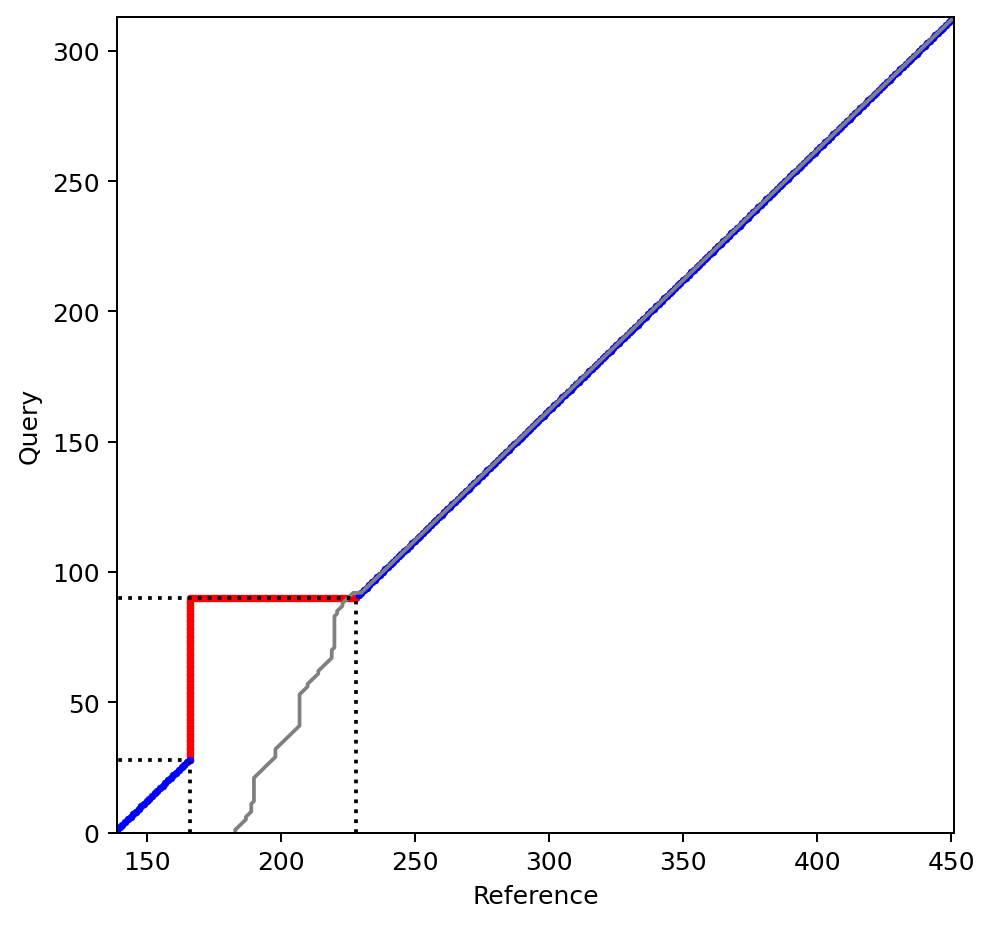

In [43]:
# replacement correct
query_id = '10_6_17'
edit_type = 'r'
piece = 6
path_v, path_h = alignNWTWDP(query_id, edit_type, piece, 100)
path_d = alignDTW(query_id, edit_type, piece)

path1 = []
for i in range(0, 28):
    path1.append([i, 166])
path1 = np.array(path1)
path2 = []
for i in range(0, 90):
    path2.append([i, 228])
path2 = np.array(path2)

path3 = []
for i in range(0, 166):
    path3.append([28, i])
path3 = np.array(path3)
path4 = []
for i in range(0, 228):
    path4.append([90, i])
path4 = np.array(path4)

plt.figure(figsize=(6, 6), dpi=180)
plt.scatter(path_h[:, 1], path_h[:, 0], s=2**2, color='red')
plt.scatter(path_v[:, 1], path_v[:, 0], s=2**2, color='blue')
plt.plot(path_d[:,1], path_d[:,0], color='gray')
plt.plot(path1[:,1], path1[:,0], ':', color='black')
plt.plot(path2[:,1], path2[:,0], ':', color='black')
plt.plot(path3[:,1], path3[:,0], ':', color='black')
plt.plot(path4[:,1], path4[:,0], ':', color='black')
plt.xlabel("Reference")
plt.ylabel("Query")
plt.ylim(0, 313) 
plt.xlim(139, 451) 

(139.0, 288.0)

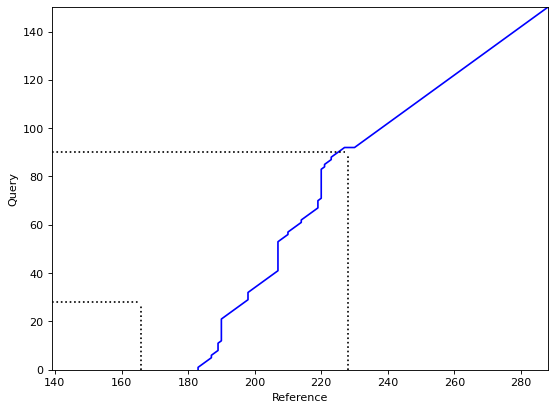

In [159]:
query_id = '10_6_17'
edit_type = 'r'
piece = 6
path_v, path_h = alignNWTWDP(query_id, edit_type, piece, 100)
path_d = alignDTW(query_id, edit_type, piece)

path1 = []
for i in range(0, 28):
    path1.append([i, 166])
path1 = np.array(path1)
path2 = []
for i in range(0, 90):
    path2.append([i, 228])
path2 = np.array(path2)

path3 = []
for i in range(0, 166):
    path3.append([28, i])
path3 = np.array(path3)
path4 = []
for i in range(0, 228):
    path4.append([90, i])
path4 = np.array(path4)

plt.figure(figsize=(6, 6), dpi=80)
plt.scatter(path_h[:, 1], path_h[:, 0], s=2**2, color='red')
plt.scatter(path_v[:, 1], path_v[:, 0], s=2**2, color='blue')
plt.plot(path_d[:,1], path_d[:,0], color='blue')
plt.plot(path1[:,1], path1[:,0], ':', color='black')
plt.plot(path2[:,1], path2[:,0], ':', color='black')
plt.plot(path3[:,1], path3[:,0], ':', color='black')
plt.plot(path4[:,1], path4[:,0], ':', color='black')
plt.xlabel("Reference")
plt.ylabel("Query")
plt.ylim(0, 150) 
plt.xlim(139, 288) 

(1997.0, 2308.0)

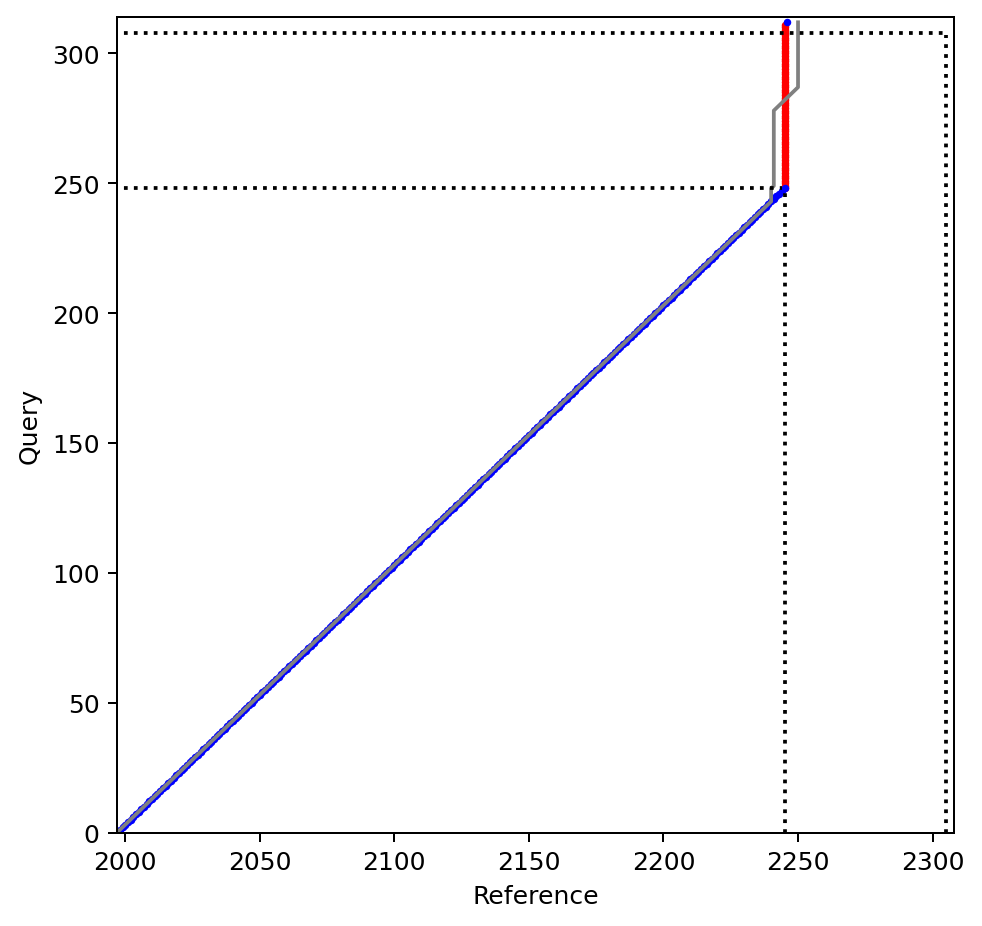

In [42]:
# replacement wrong
query_id = '10_6_17'
edit_type = 'r'
piece = 3
path_v, path_h = alignNWTWDP(query_id, edit_type, piece, 40)
path_d = alignDTW(query_id, edit_type, piece)

path1 = []
for i in range(0, 248):
    path1.append([i, 2245])
path1 = np.array(path1)
path2 = []
for i in range(0, 308):
    path2.append([i, 2305])
path2 = np.array(path2)

path3 = []
for i in range(0, 2245):
    path3.append([248, i])
path3 = np.array(path3)
path4 = []
for i in range(0, 2305):
    path4.append([308, i])
path4 = np.array(path4)

plt.figure(figsize=(6, 6), dpi=180)
plt.scatter(path_h[:, 1], path_h[:, 0], s=2**2, color='red')
plt.scatter(path_v[:, 1], path_v[:, 0], s=2**2, color='blue')
plt.plot(path_d[:,1], path_d[:,0], color='gray')
plt.plot(path1[:,1], path1[:,0], ':', color='black')
plt.plot(path2[:,1], path2[:,0], ':', color='black')
plt.plot(path3[:,1], path3[:,0], ':', color='black')
plt.plot(path4[:,1], path4[:,0], ':', color='black')
plt.xlabel("Reference")
plt.ylabel("Query")
plt.ylim(0, 314) 
plt.xlim(1997, 2308) 

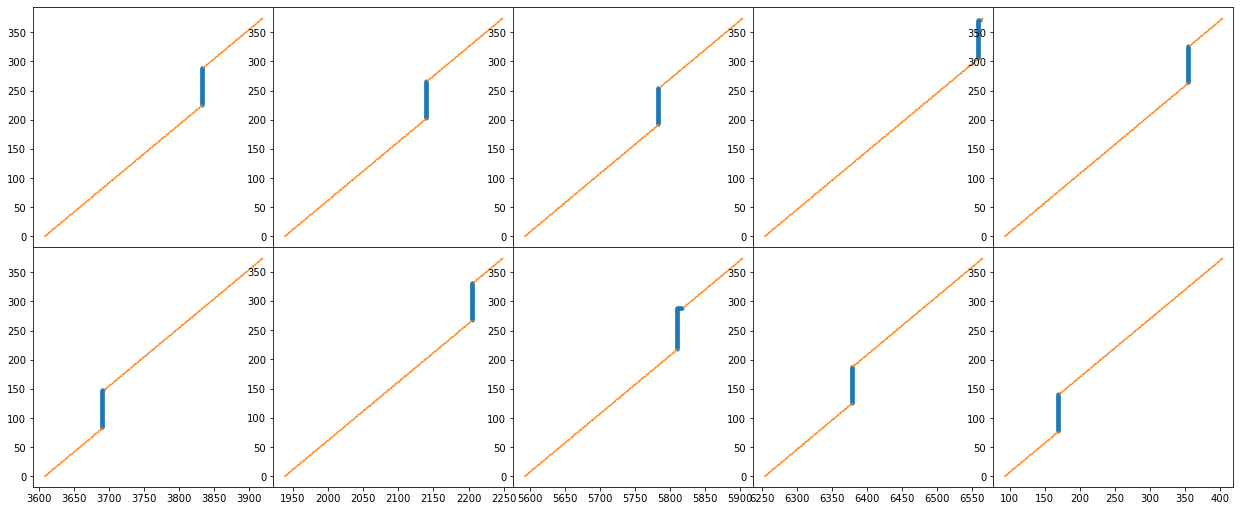

In [104]:
query_id = '3_25_17'
edit_type = 'i'
fig = plt.figure(figsize=(20, 10)) 
nrow = 2
ncol = 5
gs = gridspec.GridSpec(nrow, ncol,
         wspace=0.0, hspace=0.0, 
         top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), 
         left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 
for i in range(nrow):
    for j in range(ncol):
        ax = plt.subplot(gs[i,j])
        piece = i * 5 + j + 1
        path_v, path_h = alignNWTWDP(query_id, edit_type, piece, 7)
        plt.scatter(path_h[:, 1], path_h[:, 0], s=3**2)
        plt.scatter(path_v[:, 1], path_v[:, 0], s=0.5**2)
        #ax.set_xticklabels([])
        #ax.set_yticklabels([])